# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
### Purpose

We'll investigate if we can build up on the results of Part 13, where we observed that resistance against a 2-hidden layer model can provide resistance against a 1-hidden layer model. We'll provide resisance against a "deep" "big" feed forward network and see if smallers nets are protected against.

We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

## 1. LESS Advanced CNN collateral model

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.advanced_epochs = 20
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

We define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the test function, we just test the performance for the main and collateral tasks.

In [4]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced_collateral, advanced_idx=-1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        if not advanced_collateral:
            # Optimize C and F parts of the model with 2 strategies
            if initial_phase:  # Normal optimisation of C
                # Phase 1: Optimise Q + C
                optimizer.zero_grad()
                output = model.forward_char(data)
                loss_char = F.nll_loss(output, target_char)
                loss_char.backward()
                optimizer.step()
            else: # Freezed(Q) optimisation
                # Phase 1: Optimise Freezed(Q) + C
                model.freeze('quad')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)
                loss_char.backward()
                optimizer.step()
                model.unfreeze()
            # Phase 2: Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()

            if perturbate:
                # Optimize Q
                model.freeze('font')
                model.freeze('char')
                optimizer.zero_grad()
                output_char = model.forward_char(data)
                loss_char = F.nll_loss(output_char, target_char)

                output_font = model.forward_font(data)
                loss_font = F.nll_loss(output_font, target_font)

                loss = loss_char - alpha * loss_font
                loss.backward()
                optimizer.step()
                model.unfreeze()
        else:
            loss_char = None
            # advanced_collateral phase: use the advanced model
            model.freeze('quad')
            optimizer.zero_grad()
            output = model.forward_font_advanced(data, advanced_idx)
            loss_font = F.nll_loss(output, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        if loss_char is not None:
            loss_char = loss_char.item()
        else:
            loss_char = 0
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char, loss_font.item()))

In [5]:
def test(args, model, test_loader, advanced_collateral, advanced_idx=-1):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not advanced_collateral:
                output = model.forward_font(data)
            else:
                output = model.forward_font_advanced(data, advanced_idx)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [6]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [7]:
def main(alpha, architectures):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet(architectures)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    # Baseline training with collateral learning phase & protection
    collateral_setup_epochs = args.epochs + args.sabotage_epochs + args.recovering_epochs 
    for epoch in range(1, collateral_setup_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print(f"({epoch} initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print(f"({epoch} perturbate)")
        advanced = epoch > args.epochs + args.sabotage_epochs + args.recovering_epochs
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, advanced)
        test_perf_char, test_perf_font = test(args, model, test_loader, advanced)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)
      
    test_perfs_font_dict = {}
    for model_idx in range(len(model.advanced_nets)):
        collateral_accuracies = []
        for epoch in range(collateral_setup_epochs + 1, collateral_setup_epochs + args.advanced_epochs + 1):
            print(f"({epoch} advanced)")
            train(args, model, train_loader, optimizer, epoch, alpha, 
                initial_phase=False,
                perturbate=False,
                advanced_collateral=True,
                advanced_idx=model_idx)
            _, collateral_accuracy = test(
                args, model, test_loader, 
                advanced_collateral=True,
                advanced_idx=model_idx)
            collateral_accuracies.append(collateral_accuracy)
            
        test_perfs_font_dict[f"advanced_model_{model_idx}"] = test_perfs_font + collateral_accuracies

    return test_perfs_char, test_perfs_font_dict, model

We first test with our best trade-off (alpha = 1.5)

In [8]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self, architectures):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFNs for font families + font families advanced
        self.architectures = architectures
        self.advanced_nets = self.architectures[:-1]
        for net_idx, architecture in enumerate(architectures):
            n_layer = len(architecture) + 1
            input_size = 8
            for i_layer, output_size in enumerate(architecture):
                setattr(self, f"net_{net_idx}_{i_layer}", nn.Linear(input_size, output_size))
                input_size = output_size
            setattr(self, f"net_{net_idx}_{n_layer}", nn.Linear(input_size, N_FONTS))        
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        net_idx = len(self.architectures) - 1
        return self.conv_font_advanced(x, net_idx)
    
    def conv_font_advanced(self, x, net_idx):
        # --- FFN
        architecture = self.architectures[net_idx]
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{net_idx}_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{net_idx}_{n_layer}")  
        x = linear(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font_advanced(self, x, i):
        x = self.quad(x)
        x = self.conv_font_advanced(x, i)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            net_idx = len(self.architectures) - 1
            architecture = self.architectures[-1]
            n_layer = len(architecture) + 1
            layers = []
            for i_layer, output_size in enumerate(architecture):
                linear = getattr(self, f"net_{net_idx}_{i_layer}")
                layers.append(linear)
            linear = getattr(self, f"net_{net_idx}_{n_layer}")  
            layers.append(linear)
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

In [9]:
results = {}
font_net = [64, 32, 16, 8]
alpha=1
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]] + [font_net]
test_perfs_char, test_perfs_font_dict, model = main(alpha, architectures)
assert len(test_perfs_font_dict) < 9
for title, perf in test_perfs_font_dict.items():
    advanced_model_idx = int(title[-1])
    architecture = [8] + architectures[advanced_model_idx] + [N_FONTS]
    architecture = ':'.join(map(str, architecture))
    results[f"Collateral task with net {architecture}"] = perf
results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char

Training set 60000 items
Testing set  10000 items
net_0_0
net_0_1
net_0_2
net_0_3
net_0_5
net_1_0
net_1_1
net_1_2
net_1_4
net_2_0
net_2_1
net_2_3
net_3_0
net_3_2
net_4_0
net_4_2
net_5_0
net_5_2
net_6_0
net_6_1
net_6_2
net_6_3
net_6_5
(1 initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.286883 Loss Font: 1.611867
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.242069 Loss Font: 1.631388
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.146220 Loss Font: 1.624035
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.046387 Loss Font: 1.600302
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.712863 Loss Font: 1.604281
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.597614 Loss Font: 1.616051
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.364426 Loss Font: 1.602642
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.834164 Loss Font: 1.601808
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.919461 Loss Font: 1.618180
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.824262 Loss Font: 1.607011

Tes

Train Epoch: 10 [25600/60000 (43%)]	Loss Char: 0.137989 Loss Font: 1.310979
Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.207151 Loss Font: 1.374041
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.062182 Loss Font: 1.270912
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.230830 Loss Font: 1.189787
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.146945 Loss Font: 1.261673
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.136834 Loss Font: 1.300022

Test set: Accuracy Char : 9313/10000 (93.13%)
          Accuracy Font : 4600/10000 (46.00%)
(11 perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.178304 Loss Font: 1.201677
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.276362 Loss Font: 1.319872
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.171008 Loss Font: 1.419858
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.520031 Loss Font: 1.531058
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.097238 Loss Font: 1.377116
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.326091 Loss 


Test set: Accuracy Char : 9173/10000 (91.73%)
          Accuracy Font : 3153/10000 (31.53%)
(20 perturbate)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.207880 Loss Font: 1.591617
Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.172264 Loss Font: 1.463071
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.273321 Loss Font: 1.516556
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.348122 Loss Font: 1.540327
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.149684 Loss Font: 1.461940
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.083341 Loss Font: 1.519803
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.200896 Loss Font: 1.558244
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.150113 Loss Font: 1.380251
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.040702 Loss Font: 1.539687
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.388927 Loss Font: 1.563330

Test set: Accuracy Char : 9216/10000 (92.16%)
          Accuracy Font : 3158/10000 (31.58%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.

Train Epoch: 29 [44800/60000 (75%)]	Loss Char: 0.210465 Loss Font: 1.421873
Train Epoch: 29 [51200/60000 (85%)]	Loss Char: 0.098801 Loss Font: 1.437945
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.104235 Loss Font: 1.544493

Test set: Accuracy Char : 9260/10000 (92.60%)
          Accuracy Font : 3716/10000 (37.16%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.190936 Loss Font: 1.518899
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.180337 Loss Font: 1.460021
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.277122 Loss Font: 1.298476
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.119394 Loss Font: 1.480155
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.129449 Loss Font: 1.432968
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.061791 Loss Font: 1.385908
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.088608 Loss Font: 1.406169
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.172381 Loss Font: 1.533525
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.130224 Loss Font: 1.490375
T

Train Epoch: 39 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.550141
Train Epoch: 39 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.519631
Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.509770
Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.499041
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.533622
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.500472
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.440316
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.508997

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2895/10000 (28.95%)
(40 advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.520959
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.559650
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.509729
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 48 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.444131
Train Epoch: 48 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.496788

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 3492/10000 (34.92%)
(49 advanced)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.448253
Train Epoch: 49 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.686262
Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.635128
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.546318
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.472330
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.607493
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.457507
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.454771
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.543854
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.575300
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.543424
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.579075
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.536197
Train Epoch: 38 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.516838
Train Epoch: 38 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.542465
Train Epoch: 38 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.571625

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2751/10000 (27.51%)
(39 advanced)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.560222
Train Epoch: 39 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.492210
Train Epoch: 39 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.501411
Train Epoch: 39 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.545104
Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 47 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.484223

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 3015/10000 (30.15%)
(48 advanced)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.626690
Train Epoch: 48 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.484503
Train Epoch: 48 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.451829
Train Epoch: 48 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.490561
Train Epoch: 48 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.501417
Train Epoch: 48 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.519089
Train Epoch: 48 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.553346
Train Epoch: 48 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.562279
Train Epoch: 48 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.517742
Train Epoch: 48 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.529793

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accura

Train Epoch: 37 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.549255
Train Epoch: 37 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.542716
Train Epoch: 37 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.512674
Train Epoch: 37 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.586777
Train Epoch: 37 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.611560
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.533840

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2796/10000 (27.96%)
(38 advanced)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.571419
Train Epoch: 38 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.574906
Train Epoch: 38 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.505589
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.531265
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.547338
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Fo


Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2907/10000 (29.07%)
(47 advanced)
Train Epoch: 47 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.609421
Train Epoch: 47 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.510807
Train Epoch: 47 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.615109
Train Epoch: 47 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.541323
Train Epoch: 47 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.533278
Train Epoch: 47 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.523450
Train Epoch: 47 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.571101
Train Epoch: 47 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.449231
Train Epoch: 47 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.511042
Train Epoch: 47 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.505076

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2941/10000 (29.41%)
(48 advanced)
Train Epoch: 48 [0/60000 (0%)]	L

Train Epoch: 36 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.476763
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.531104
Train Epoch: 36 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.529276
Train Epoch: 36 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.609991
Train Epoch: 36 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.538263

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 3062/10000 (30.62%)
(37 advanced)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.566261
Train Epoch: 37 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.596118
Train Epoch: 37 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.544389
Train Epoch: 37 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.557063
Train Epoch: 37 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.478905
Train Epoch: 37 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.567195
Train Epoch: 37 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 46 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.472549
Train Epoch: 46 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.489657
Train Epoch: 46 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.482852
Train Epoch: 46 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.439814
Train Epoch: 46 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.506060
Train Epoch: 46 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.490565
Train Epoch: 46 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.506084
Train Epoch: 46 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.392382
Train Epoch: 46 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.544198

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 3527/10000 (35.27%)
(47 advanced)
Train Epoch: 47 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.566404
Train Epoch: 47 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.441283
Train Epoch: 47 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Fon

Train Epoch: 35 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.536943
Train Epoch: 35 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.529470
Train Epoch: 35 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.541660

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2750/10000 (27.50%)
(36 advanced)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.607070
Train Epoch: 36 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.476816
Train Epoch: 36 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.569909
Train Epoch: 36 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.474198
Train Epoch: 36 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.660217
Train Epoch: 36 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.633641
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.545004
Train Epoch: 36 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.551713
Train Epoch: 36 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 45 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.596812
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.522217
Train Epoch: 45 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.595181
Train Epoch: 45 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.524556
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.518400
Train Epoch: 45 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.515861
Train Epoch: 45 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.554424
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.502762

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 3061/10000 (30.61%)
(46 advanced)
Train Epoch: 46 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.496639
Train Epoch: 46 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.498552
Train Epoch: 46 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.601124
Train Epoch: 46 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 34 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.592839
Train Epoch: 34 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.583230

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2381/10000 (23.81%)
(35 advanced)
Train Epoch: 35 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.557407
Train Epoch: 35 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.579368
Train Epoch: 35 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.618487
Train Epoch: 35 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.578278
Train Epoch: 35 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.628275
Train Epoch: 35 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.597879
Train Epoch: 35 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.582417
Train Epoch: 35 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.597937
Train Epoch: 35 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.574850
Train Epoch: 35 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.559492
Train Epoch: 44 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.586657
Train Epoch: 44 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.664143
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.592477
Train Epoch: 44 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.589143
Train Epoch: 44 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.537830
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.560677

Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 2758/10000 (27.58%)
(45 advanced)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.578184
Train Epoch: 45 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.533315
Train Epoch: 45 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.558841
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.539072
Train Epoch: 45 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Fo

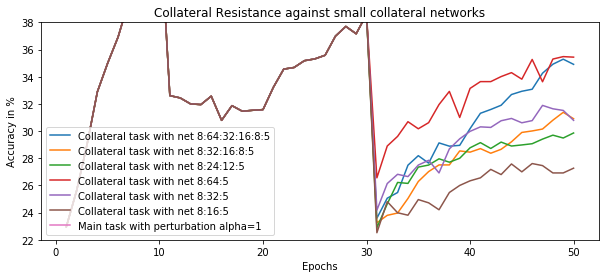

In [13]:
show_results(results, "Collateral Resistance against various FFN", ymin=22, ymax=38)

As we observe, the collateral resistance remains overall good, with a collateral accuracy which doesn't exceed 36%. However, the red curve with the highest accuracy is not the one corresponding to the most complicated network (the one the used in the sabotaged collateral task). As the last epochs suggest, the reason for its good performance is mainly that the model is of lower depth and hence improves faster than other: in the last 3 epochs, the accuracy of this model and of the model sabotaged are alsmot equivalent, which suggests that the defence process is good.

### Long term advantage
Let's verify this, by comparing just these two last models on a longer period. The other models seem to be completely out performed.

In [17]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.advanced_epochs = 40
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [18]:
results1 = {}
font_net = [64, 32, 16, 8]
alpha=1
architectures = [[64, 32, 16, 8], [64]] + [font_net]
test_perfs_char, test_perfs_font_dict, model = main(alpha, architectures)
assert len(test_perfs_font_dict) < 9
for title, perf in test_perfs_font_dict.items():
    advanced_model_idx = int(title[-1])
    architecture = [8] + architectures[advanced_model_idx] + [N_FONTS]
    architecture = ':'.join(map(str, architecture))
    results1[f"Collateral task with net {architecture}"] = perf
results1[f"Main task with perturbation alpha={alpha}"] = test_perfs_char

Training set 60000 items
Testing set  10000 items
net_0_0
net_0_1
net_0_2
net_0_3
net_0_5
net_1_0
net_1_2
net_2_0
net_2_1
net_2_2
net_2_3
net_2_5
(1 initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.280272 Loss Font: 1.607234
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.216319 Loss Font: 1.626654
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.217819 Loss Font: 1.618391
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.005855 Loss Font: 1.597190
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.678994 Loss Font: 1.617843
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.414797 Loss Font: 1.605195
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.278966 Loss Font: 1.609420
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.009065 Loss Font: 1.600388
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.637693 Loss Font: 1.597921
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.465956 Loss Font: 1.616700

Test set: Accuracy Char : 5006/10000 (50.06%)
          Accuracy Font : 2202/10000 (22.02%)

Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.108786 Loss Font: 1.213208
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.187780 Loss Font: 1.213912
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.417970 Loss Font: 1.150598
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.250633 Loss Font: 1.268675
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.132595 Loss Font: 1.268814

Test set: Accuracy Char : 9284/10000 (92.84%)
          Accuracy Font : 4973/10000 (49.73%)
(11 perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.113308 Loss Font: 1.183562
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.212434 Loss Font: 1.358172
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.087016 Loss Font: 1.412074
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.135726 Loss Font: 1.433122
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.546135 Loss Font: 1.416995
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.169992 Loss Font: 1.529991
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.336018 Loss 

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.041951 Loss Font: 1.539011
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.055329 Loss Font: 1.439185
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.136092 Loss Font: 1.554759
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.325928 Loss Font: 1.587371
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.183022 Loss Font: 1.545789
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.162698 Loss Font: 1.600507
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.124632 Loss Font: 1.446293
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.131862 Loss Font: 1.553053
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.143219 Loss Font: 1.497197

Test set: Accuracy Char : 9116/10000 (91.16%)
          Accuracy Font : 3254/10000 (32.54%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.310107 Loss Font: 1.538334
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.205365 Loss Font: 1.499881
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.199164 Loss Font: 1.427964
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.454746 Loss Font: 1.530760

Test set: Accuracy Char : 9216/10000 (92.16%)
          Accuracy Font : 3750/10000 (37.50%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.112277 Loss Font: 1.379990
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.138030 Loss Font: 1.330070
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.162338 Loss Font: 1.440017
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.114514 Loss Font: 1.405078
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.145822 Loss Font: 1.277468
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.062217 Loss Font: 1.421007
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.158042 Loss Font: 1.413321
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.076027 Loss Font: 1.410015
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.111164 Loss Font: 1.343307
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.122082 Loss Font: 1.522340

Test set: Accuracy Char : 9215/10000 (92.15%)
          Accuracy Font : 3816

Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.566705
Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.528429
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.621931
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.531566
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.516514
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.510102

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3053/10000 (30.53%)
(40 advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.571608
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.573581
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.572843
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.539864
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.586939
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Fo


Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3327/10000 (33.27%)
(49 advanced)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.488873
Train Epoch: 49 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.454304
Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.514956
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.497000
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.456683
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.499400
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.559610
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.399756
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.418574
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.522505

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3309/10000 (33.09%)
(50 advanced)
Train Epoch: 50 [0/60000 (0%)]	L

Train Epoch: 58 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.424564
Train Epoch: 58 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.390414
Train Epoch: 58 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.537317
Train Epoch: 58 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.448396
Train Epoch: 58 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.387326

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3725/10000 (37.25%)
(59 advanced)
Train Epoch: 59 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.468520
Train Epoch: 59 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.445346
Train Epoch: 59 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.477965
Train Epoch: 59 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.400020
Train Epoch: 59 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.410262
Train Epoch: 59 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.460920
Train Epoch: 59 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 68 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.374081
Train Epoch: 68 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.424632
Train Epoch: 68 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.329243
Train Epoch: 68 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.403025
Train Epoch: 68 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.354553
Train Epoch: 68 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.399787
Train Epoch: 68 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.439619
Train Epoch: 68 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.414904
Train Epoch: 68 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.292217

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3865/10000 (38.65%)
(69 advanced)
Train Epoch: 69 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.542620
Train Epoch: 69 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.435601
Train Epoch: 69 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Fon

Train Epoch: 37 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.584497
Train Epoch: 37 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.515017
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.557498

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3158/10000 (31.58%)
(38 advanced)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.571520
Train Epoch: 38 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.529889
Train Epoch: 38 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.587090
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.455410
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.498363
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.529545
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.558482
Train Epoch: 38 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.564776
Train Epoch: 38 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 47 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.444358
Train Epoch: 47 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.625553
Train Epoch: 47 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.561109
Train Epoch: 47 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.472840
Train Epoch: 47 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.448331
Train Epoch: 47 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.478224
Train Epoch: 47 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.454889
Train Epoch: 47 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.430345

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3463/10000 (34.63%)
(48 advanced)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.628092
Train Epoch: 48 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.531096
Train Epoch: 48 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.545451
Train Epoch: 48 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 56 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.462481
Train Epoch: 56 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.492629

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3609/10000 (36.09%)
(57 advanced)
Train Epoch: 57 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.443497
Train Epoch: 57 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.532775
Train Epoch: 57 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.507923
Train Epoch: 57 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.439555
Train Epoch: 57 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.392379
Train Epoch: 57 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.479370
Train Epoch: 57 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.503239
Train Epoch: 57 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.421875
Train Epoch: 57 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.391497
Train Epoch: 57 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 66 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.616730
Train Epoch: 66 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.460145
Train Epoch: 66 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.460010
Train Epoch: 66 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.386486
Train Epoch: 66 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.521882
Train Epoch: 66 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.416897
Train Epoch: 66 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.513703

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 3549/10000 (35.49%)
(67 advanced)
Train Epoch: 67 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.509503
Train Epoch: 67 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.420467
Train Epoch: 67 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.425328
Train Epoch: 67 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.421285
Train Epoch: 67 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Fo

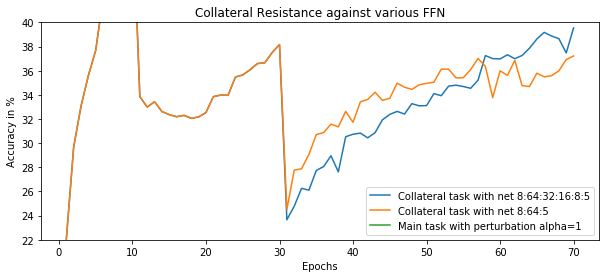

In [20]:
show_results(results1, "Collateral Resistance against various FFN", ymin=22, ymax=40)

**Observation**: our intuition is confirmed, the least deep model improves faster but gets outperformed by the more complex one after a sufficient period.

Now, we can wonder what would happen if we protect against the least deep model, as they both perform well, and this protection would cost less.

### Changing the resistance target

Let's now try to inverse the model which is sabotaged, so now it the one with a single hidden layer.

In [25]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 3
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.advanced_epochs = 40
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [26]:
results2 = {}
font_net = [64]
alpha=1
architectures = [[64, 32, 16, 8], [64]] + [font_net]
test_perfs_char, test_perfs_font_dict, model = main(alpha, architectures)
assert len(test_perfs_font_dict) < 9
for title, perf in test_perfs_font_dict.items():
    advanced_model_idx = int(title[-1])
    architecture = [8] + architectures[advanced_model_idx] + [N_FONTS]
    architecture = ':'.join(map(str, architecture))
    results2[f"Collateral task with net {architecture}"] = perf
results2[f"Main task with perturbation alpha={alpha}"] = test_perfs_char

Training set 60000 items
Testing set  10000 items
net_0_0
net_0_1
net_0_2
net_0_3
net_0_5
net_1_0
net_1_2
net_2_0
net_2_2
(1 initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.281370 Loss Font: 1.616350
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.241950 Loss Font: 1.592818
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.166342 Loss Font: 1.600709
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.017994 Loss Font: 1.570842
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.777882 Loss Font: 1.594103
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.585015 Loss Font: 1.611913
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.265573 Loss Font: 1.628654
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.785371 Loss Font: 1.556702
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.886389 Loss Font: 1.524961
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.771755 Loss Font: 1.533813

Test set: Accuracy Char : 5107/10000 (51.07%)
          Accuracy Font : 2841/10000 (28.41%)
(2 initial phase)
Train

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.126654 Loss Font: 1.552703
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.157190 Loss Font: 1.565143
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.093274 Loss Font: 1.607676
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.192005 Loss Font: 1.574931

Test set: Accuracy Char : 8250/10000 (82.50%)
          Accuracy Font : 2615/10000 (26.15%)
(11 perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.133449 Loss Font: 1.612151
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.342319 Loss Font: 1.622247
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.260234 Loss Font: 1.548220
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.427772 Loss Font: 1.561630
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.130118 Loss Font: 1.517817
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.267485 Loss Font: 1.531121
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.225661 Loss Font: 1.504066
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.130305 Loss 

Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.132262 Loss Font: 1.540521
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.177939 Loss Font: 1.465555
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.210990 Loss Font: 1.477951
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.114767 Loss Font: 1.463333
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.104798 Loss Font: 1.501920
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.294526 Loss Font: 1.472974
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.210262 Loss Font: 1.423040
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.189709 Loss Font: 1.546397

Test set: Accuracy Char : 9006/10000 (90.06%)
          Accuracy Font : 3257/10000 (32.57%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.212915 Loss Font: 1.469937
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.323339 Loss Font: 1.472025
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.233709 Loss Font: 1.514181
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.269515 Loss Font: 1.508559
T

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.577503

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 2438/10000 (24.38%)
(30 advanced)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.605643
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.580649
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.549878
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.572956
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.565446
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.550620
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.575051
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.580063
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.633707
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.586767

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accura

Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.477360
Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.501030
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.453822
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.574749
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.468673
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.570631

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 3144/10000 (31.44%)
(40 advanced)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.434610
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.472946
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.564351
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.474018
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.428769
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Fo


Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 3534/10000 (35.34%)
(49 advanced)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.490892
Train Epoch: 49 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.541243
Train Epoch: 49 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.440561
Train Epoch: 49 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.435202
Train Epoch: 49 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.474872
Train Epoch: 49 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.425607
Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.368335
Train Epoch: 49 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.364545
Train Epoch: 49 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.334368
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.443655

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 3592/10000 (35.92%)
(50 advanced)
Train Epoch: 50 [0/60000 (0%)]	L

Train Epoch: 58 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.558307
Train Epoch: 58 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.309981
Train Epoch: 58 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.405591
Train Epoch: 58 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.362445
Train Epoch: 58 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.488870

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 3977/10000 (39.77%)
(59 advanced)
Train Epoch: 59 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.412820
Train Epoch: 59 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.275323
Train Epoch: 59 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.339300
Train Epoch: 59 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.366212
Train Epoch: 59 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.427767
Train Epoch: 59 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.327914
Train Epoch: 59 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 28 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.550726
Train Epoch: 28 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.562983
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.509045
Train Epoch: 28 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.582388
Train Epoch: 28 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.542851
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.631966
Train Epoch: 28 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.554067
Train Epoch: 28 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.549745
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.498179

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 2865/10000 (28.65%)
(29 advanced)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.539589
Train Epoch: 29 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.604327
Train Epoch: 29 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Fon

Train Epoch: 37 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.482332
Train Epoch: 37 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.517653
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.492395

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 3047/10000 (30.47%)
(38 advanced)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.504152
Train Epoch: 38 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.657457
Train Epoch: 38 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.573820
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.658719
Train Epoch: 38 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.556665
Train Epoch: 38 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.464968
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.462785
Train Epoch: 38 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.498093
Train Epoch: 38 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 47 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.454831
Train Epoch: 47 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.531903
Train Epoch: 47 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.454756
Train Epoch: 47 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.481776
Train Epoch: 47 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.508708
Train Epoch: 47 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.454610
Train Epoch: 47 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.573063
Train Epoch: 47 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.470241

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 3105/10000 (31.05%)
(48 advanced)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.447471
Train Epoch: 48 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.559539
Train Epoch: 48 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.473580
Train Epoch: 48 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Fo

Train Epoch: 56 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.444683
Train Epoch: 56 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.448483

Test set: Accuracy Char : 9069/10000 (90.69%)
          Accuracy Font : 3243/10000 (32.43%)
(57 advanced)
Train Epoch: 57 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.474333
Train Epoch: 57 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.453120
Train Epoch: 57 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.487898
Train Epoch: 57 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.492353
Train Epoch: 57 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.514361
Train Epoch: 57 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.513800
Train Epoch: 57 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.508224
Train Epoch: 57 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.455571
Train Epoch: 57 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.466804
Train Epoch: 57 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Fo

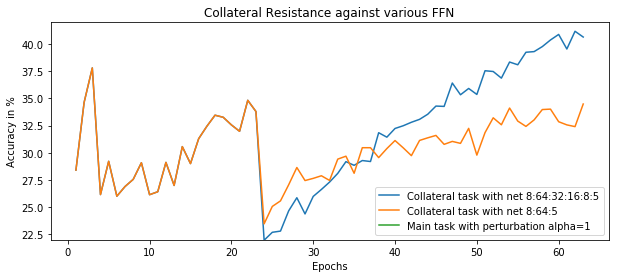

In [28]:
show_results(results2, "Collateral Resistance against various FFN", ymin=22, ymax=42)

**Observation** Here we observe that the most complex model succeeds in improving accuracy faster than before, and it's outperforming the simplest model is clear. It's final accuracy after 40 epochs is now 41%, compared to 39.5% in the last setting. So this is not a big difference, but in terms of resistance and collateral task, it makes a difference.

## Conclusion
These experiments confirm that protecting against a sufficiently large FFN is a good approach to have a general resistance against the FFN family. By sufficiently large, we mean that adding more layers would not make the model _much_ better, and therefore very large models would perform a bit better in the collateral task but not significantly to gain a strategic advantage.